<a href="https://colab.research.google.com/github/MatteoAldovardi92/Taxi_Project/blob/main/Geographical_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mnavas/taxi-routes-for-mexico-city-and-quito")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/taxi-routes-for-mexico-city-and-quito


In [105]:
import os

# Show files inside the dataset directory
print("Dataset contents:")
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))


Dataset contents:
/kaggle/input/taxi-routes-for-mexico-city-and-quito/mex_clean.csv
/kaggle/input/taxi-routes-for-mexico-city-and-quito/uio_clean.csv
/kaggle/input/taxi-routes-for-mexico-city-and-quito/all-data_clean.csv
/kaggle/input/taxi-routes-for-mexico-city-and-quito/bog_clean.csv


In [106]:
import pandas as pd
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("mnavas/taxi-routes-for-mexico-city-and-quito")

# Load each CSV as a separate DataFrame
bog_df = pd.read_csv(os.path.join(path, "bog_clean.csv"))
uio_df = pd.read_csv(os.path.join(path, "uio_clean.csv"))
mex_df = pd.read_csv(os.path.join(path, "mex_clean.csv"))
all_df = pd.read_csv(os.path.join(path, "all-data_clean.csv"))

# Preview one
print(all_df.head())


   id              vendor_id      pickup_datetime     dropoff_datetime  \
0   1                  Quito  2016-09-17 09:32:06  2016-09-17 10:05:51   
1   2  Guadalajara Easy Taxi  2016-09-17 09:59:54  2016-09-17 10:06:23   
2   3              Monterrey  2016-09-17 10:06:52  2016-09-17 10:09:40   
3   4              Monterrey  2016-09-17 09:45:56  2016-09-17 10:13:34   
4   5              Monterrey  2016-09-17 10:12:00  2016-09-17 10:16:31   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          0.632055         0.528947         -78.549447         -0.361363   
1          0.327804         0.391950        -103.366600         20.686971   
2          0.140910         0.563280        -100.165737         25.619387   
3          0.207565         0.590416        -100.491721         25.676294   
4          0.128881         0.580419        -100.104166         25.643862   

  store_and_fwd_flag  trip_duration  dist_meters  wait_sec  
0                  N           

In [107]:
bog_coord = (4.652238, -74.116886)
uio_coord = (-0.220005, -78.512506)
mex_coord = (19.420083, -99.144867)

In [108]:
            ### Small library of functions ###
################################################################################



import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

def plot_kmeans_clusters(df, location_type='pickup', n_clusters=2, save = False):
    """
    Plots KMeans clusters for pickup or dropoff locations and returns the fitted KMeans object.

    Parameters:
    - df: DataFrame containing latitude and longitude columns.
    - location_type: 'pickup' or 'dropoff' to specify which columns to use.
    - n_clusters: number of clusters for KMeans.

    Returns:
    - kmeans: trained KMeans object.
    """
    assert location_type in ['pickup', 'dropoff'], "location_type must be 'pickup' or 'dropoff'"

    lat_col = f'{location_type}_latitude'
    lon_col = f'{location_type}_longitude'

    # Extract coordinates and convert to numpy array
    coordinates = np.array(list(zip(df[lat_col], df[lon_col])))

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(coordinates)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Prepare DataFrame for plotting
    df_plot = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])
    df_plot['cluster'] = labels

    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'gray']

    for i in range(n_clusters):
        cluster_points = df_plot[df_plot['cluster'] == i]
        color = colors[i % len(colors)]
        plt.scatter(cluster_points['longitude'], cluster_points['latitude'],
                    color=color, label=f'Cluster {i}', s=20, alpha=0.5)

    plt.scatter(centroids[:, 1], centroids[:, 0], color='black', marker='*', s=100, label='Centroids')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clusters of {location_type.capitalize()} Locations')
    plt.legend()
    if save == True:
        plt.savefig(f'{location_type}_cluster.jpg')
    plt.grid(True)
    plt.show()

    return kmeans, coordinates

from geopy.distance import geodesic


def clip_km_away(locations: pd.DataFrame, city_center, radius):
    """
    Filters out points that are more than 'radius' km away from the city center.

    Parameters:
    - locations: two columns of a dataframe containing lat, long.
                 Expects columns named 'pickup_latitude' and 'pickup_longitude'
                 or 'dropoff_latitude' and 'dropoff_longitude'.
    - city_center: tuple (lat, long)
    - radius: radius in kilometers

    Returns:
    - a boolean mask (a list or pandas Series)
    """
    # Determine which columns to use based on the columns present in the DataFrame
    if 'pickup_latitude' in locations.columns and 'pickup_longitude' in locations.columns:
        lat_col = 'pickup_latitude'
        lon_col = 'pickup_longitude'
    elif 'dropoff_latitude' in locations.columns and 'dropoff_longitude' in locations.columns:
        lat_col = 'dropoff_latitude'
        lon_col = 'dropoff_longitude'
    else:
        raise ValueError("locations DataFrame must contain 'pickup_latitude' and 'pickup_longitude' "
                         "or 'dropoff_latitude' and 'dropoff_longitude' columns.")

    # Iterate through rows and calculate distance for each point
    # Use .itertuples(index=False) for efficiency and get values as a tuple
    mask = [geodesic((row[0], row[1]), city_center).km <= radius
            for row in locations[[lat_col, lon_col]].itertuples(index=False)]

    return mask



# This function could eventually be enriched as more and more conditions comes to mind
def Clean_df(df):
  """
    Filters out rows with blatantly incorrect values.

    Parameters:
    - df : DataFrame to clean
    Returns:
    - df : cleaned DataFrame
    """

  # Explicitly define each condition for dist_meters and trip_duration
  mask_dist = (df['dist_meters'] > 200) & (df['dist_meters'] < 120 * 10**3) # trips between 200m and 120km
  mask_duration = (df['trip_duration'] > 2*60) & (df['trip_duration'] < 3*3600) # between 2 minutes and 3h

  # Combine the masks using the bitwise AND operator
  mask = mask_dist & mask_duration

  return df[mask]

################################################################################################



In [109]:
# Remove all the coordinates in a 60 km radius away from each city center.

mask_pickup_bog = clip_km_away(bog_df[['pickup_latitude', 'pickup_longitude']], bog_coord, 60)
bog_df = bog_df[mask_pickup_bog]

mask_dropoff_bog = clip_km_away(bog_df[['dropoff_latitude', 'dropoff_longitude']], bog_coord, 60)
bog_df = bog_df[mask_dropoff_bog]


mask_pickup_uio = clip_km_away(uio_df[['pickup_latitude', 'pickup_longitude']], uio_coord, 60)
uio_df = uio_df[mask_pickup_uio]

mask_dropoff_uio = clip_km_away(uio_df[['dropoff_latitude', 'dropoff_longitude']], uio_coord, 60)
uio_df = uio_df[mask_dropoff_uio]



mask_pickup_mex = clip_km_away(mex_df[['pickup_latitude', 'pickup_longitude']], mex_coord,60)
mex_df = mex_df[mask_pickup_mex]

mask_dropoff_mex = clip_km_away(mex_df[['dropoff_latitude', 'dropoff_longitude']], mex_coord, 60)
mex_df = mex_df[mask_dropoff_mex]

#Visualize the filtered positions

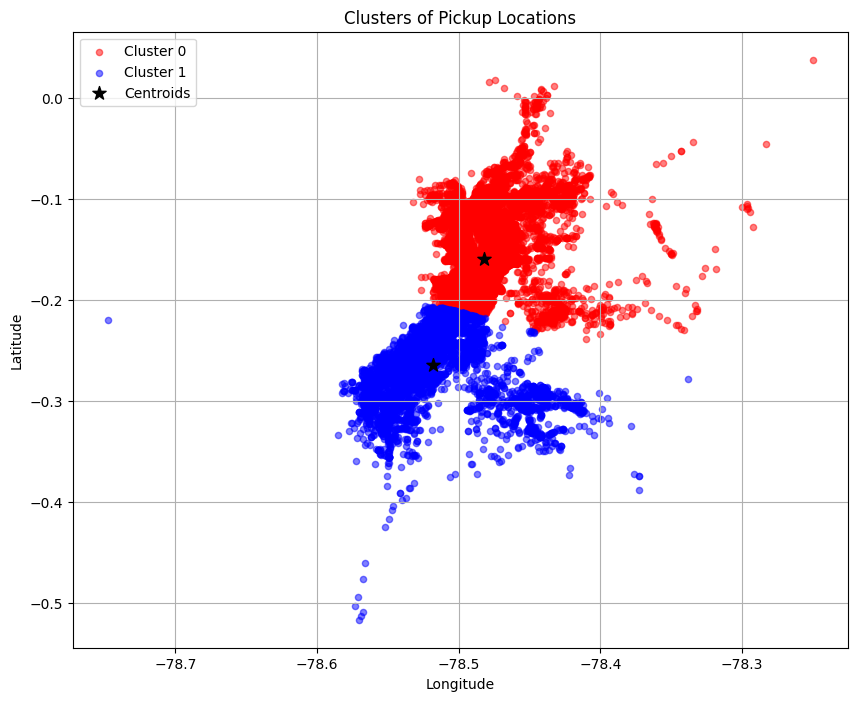

(KMeans(n_clusters=2, random_state=0),
 array([[-2.32824134e-01, -7.85039218e+01],
        [ 6.78890239e-03, -7.84403056e+01],
        [-1.43636221e-01, -7.84695514e+01],
        ...,
        [-1.07513805e-01, -7.84772472e+01],
        [-2.56730460e-01, -7.85502635e+01],
        [-3.41537955e-01, -7.84319858e+01]]))

In [110]:
plot_kmeans_clusters(uio_df, location_type='pickup', n_clusters=2, save = True)

### Apply other filters

In [111]:
bog_df = Clean_df(bog_df)
uio_df = Clean_df(uio_df)
mex_df = Clean_df(mex_df)


In [112]:
print("Bogota dataframe", bog_df.shape)
print("Quito's", uio_df.shape)
print("Mexico City's", mex_df.shape)

Bogota dataframe (2171, 12)
Quito's (27501, 12)
Mexico City's (10324, 12)


### Geodetic distance

In [113]:
from geopy.distance import geodesic

# Create geodesic distances using proper zipping
distances = [
    geodesic((lat1, lon1), (lat2, lon2)).meters
    for lat1, lon1, lat2, lon2 in zip(
        bog_df['pickup_latitude'],
        bog_df['pickup_longitude'],
        bog_df['dropoff_latitude'],
        bog_df['dropoff_longitude']
    )
]

bog_df['geodetic_dist'] = distances



distances = [
    geodesic((lat1, lon1), (lat2, lon2)).meters
    for lat1, lon1, lat2, lon2 in zip(
        uio_df['pickup_latitude'],
        uio_df['pickup_longitude'],
        uio_df['dropoff_latitude'],
        uio_df['dropoff_longitude']
    )
]

uio_df['geodetic_dist'] = distances


distances = [
    geodesic((lat1, lon1), (lat2, lon2)).meters
    for lat1, lon1, lat2, lon2 in zip(
        mex_df['pickup_latitude'],
        mex_df['pickup_longitude'],
        mex_df['dropoff_latitude'],
        mex_df['dropoff_longitude']
    )
]

mex_df['geodetic_dist'] = distances



In [114]:
mask = bog_df['geodetic_dist'] > 200 # at least 200 m
bog_df = bog_df[mask]

mask = uio_df['geodetic_dist'] > 200
uio_df = uio_df[mask]



mask = mex_df['geodetic_dist'] > 200
mex_df = mex_df[mask]

print(bog_df['geodetic_dist'].max()/1000, uio_df['geodetic_dist'].max()/1000, mex_df['geodetic_dist'].max()/1000)

41.16830619183478 45.08203284975902 50.99579427805217


In [115]:
bog_df['trip_duration'].describe()/3600 # maximum trip is 3h

,trip_duration
count,0.554722
mean,0.552777
std,0.515724
min,0.033889
25%,0.204444
50%,0.381111
75%,0.706389
max,2.997500


<Axes: >

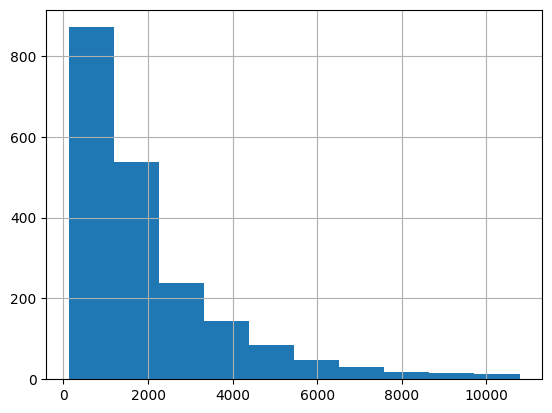

In [116]:
bog_df['trip_duration'].hist()

<Axes: >

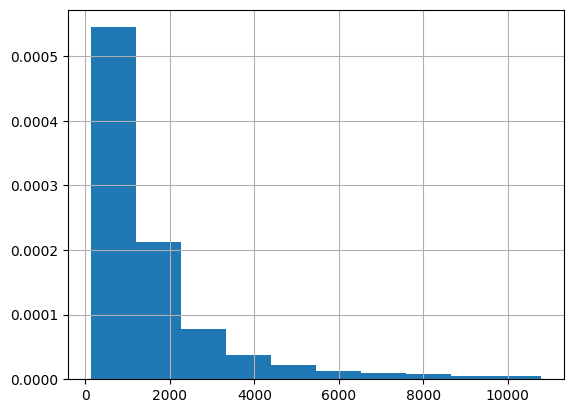

In [117]:
mex_df['trip_duration'].hist(density=True)

### Convert the trip_durations in hours to increase readability

In [118]:
bog_df['trip_duration'] = bog_df['trip_duration']/3600 # Convert the durations in hours
uio_df['trip_duration'] = uio_df['trip_duration']/3600 #
mex_df['trip_duration'] = mex_df['trip_duration']/3600 #


## Visualize the correlation between geodetic distance and distance meters

In [119]:
bog_df[['dist_meters', 'geodetic_dist']].corr()

,dist_meters,geodetic_dist
dist_meters,1.000000,0.738588
geodetic_dist,0.738588,1.000000


# Mean Velocities:

In [120]:
bog_df['mean_velocity'] = bog_df['dist_meters']/bog_df['trip_duration']
uio_df['mean_velocity'] = uio_df['dist_meters']/uio_df['trip_duration']
mex_df['mean_velocity'] = mex_df['dist_meters']/mex_df['trip_duration']


In [135]:
bog_df['mean_velocity'] = bog_df['mean_velocity']/1000 # km/h
uio_df['mean_velocity'] = uio_df['mean_velocity']/1000
mex_df['mean_velocity'] = mex_df['mean_velocity']/1000

<ipython-input-135-74d808209d12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uio_df['mean_velocity'] = uio_df['mean_velocity']/1000
<ipython-input-135-74d808209d12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mex_df['mean_velocity'] = mex_df['mean_velocity']/1000


# Drop the useless columns from the dataset

In [121]:
column_to_drop = ['id', 'vendor_id', 'store_and_fwd_flag', 'dropoff_longitude',
                  'dropoff_latitude', 'pickup_latitude', 'pickup_longitude']
bog_df = bog_df.drop(column_to_drop, axis=1)
uio_df = uio_df.drop(column_to_drop, axis=1)
mex_df = mex_df.drop(column_to_drop, axis=1)

### The trip durations obtained by subtracting the datetimes is the same as the one registered in the column trip duration.

In [125]:
a = pd.to_datetime(bog_df['pickup_datetime'])
b = pd.to_datetime(bog_df['dropoff_datetime'])
durations =  (b-a).dt.total_seconds()/3600

import numpy as np


is_close = np.isclose(bog_df['trip_duration'], durations, rtol=1e-2, atol=1e-3)

bog_df = bog_df[is_close]


np.int64(1917)

In [130]:
a = pd.to_datetime(mex_df['pickup_datetime'])
b = pd.to_datetime(mex_df['dropoff_datetime'])
durations =  (b-a).dt.total_seconds()/3600

import numpy as np


is_close = np.isclose(mex_df['trip_duration'], durations, rtol=1e-2, atol=1e-3)

mex_df = mex_df[is_close]


In [132]:
a = pd.to_datetime(uio_df['pickup_datetime'])
b = pd.to_datetime(uio_df['dropoff_datetime'])
durations =  (b-a).dt.total_seconds()/3600

import numpy as np


is_close = np.isclose(uio_df['trip_duration'], durations, rtol=1e-2, atol=1e-3)

uio_df = uio_df[is_close]

## Distances in km

In [137]:
bog_df['dist_meters'] = bog_df['dist_meters']/1000
uio_df['dist_meters'] = uio_df['dist_meters']/1000
mex_df['dist_meters'] = mex_df['dist_meters']/1000


bog_df['geodetic_dist'] = bog_df['geodetic_dist']/1000
uio_df['geodetic_dist'] = uio_df['geodetic_dist']/1000
mex_df['geodetic_dist'] = mex_df['geodetic_dist']/1000

<ipython-input-137-ed61cef0974c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uio_df['dist_meters'] = uio_df['dist_meters']/1000
<ipython-input-137-ed61cef0974c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mex_df['dist_meters'] = mex_df['dist_meters']/1000
<ipython-input-137-ed61cef0974c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

# Save all the progress:
What's left to do:
- Create the categorical feature rush hour

- Maybe use the standard scalar


- Make a model for each dataset:
  - Try ridge regressor
  - Try LightGBM
  - The pipeline should be of the following, the city entry is checked, is properly rescaled, if need polyfeatures are calculated and then the correct model is employed.


Keep in mind:
- dist and velocities are obviously correlated
- dist and geo_dist are correlated as well
- velocities are of the form dist/y where y is our target variable. Thus, a linear model will never be satisfying

In [141]:
import os
import pandas as pd

# Define path inside Google Drive
drive_path = '/content/drive/MyDrive/datasets'

# Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Save your DataFrame as CSV
bog_df.to_csv(os.path.join(drive_path, 'bog_df.csv'), index=False)
mex_df.to_csv(os.path.join(drive_path, 'mex_df.csv'), index=False)
uio_df.to_csv(os.path.join(drive_path, 'uio_df.csv'), index=False)